In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller as ADF
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.stattools import grangercausalitytests

In [3]:
df_data = pd.read_csv("data-by-day.csv")

In [26]:
df_ = df_data[["CASE_COUNT", "HOSPITALIZED_COUNT", "DEATH_COUNT" ]][289:]

In [27]:
df = df_.reset_index(drop=True)
df

,CASE_COUNT,HOSPITALIZED_COUNT,DEATH_COUNT
0,3577,259,30
1,3679,232,32
2,2783,212,39
3,1923,226,35
4,3427,273,39
...,...,...,...
360,2906,95,9
361,2935,114,12
362,1912,85,5
363,2265,79,11


In [28]:
df_dose = pd.read_csv("doses-by-day.csv")
df_dose

,DATE,ADMIN_DOSE1_DAILY,ADMIN_DOSE1_CUMULATIVE,ADMIN_DOSE2_DAILY,ADMIN_DOSE2_CUMULATIVE,ADMIN_SINGLE_DAILY,ADMIN_SINGLE_CUMULATIVE,ADMIN_ALLDOSES_DAILY,ADMIN_ALLDOSES_7DAYAVG,ADMIN_ALLDOSES_CUMULATIVE,INCOMPLETE
0,2020-12-14,79,79,0,0,0,0,79,NaN,79,0
1,2020-12-15,2053,2132,4,4,4,4,2061,NaN,2140,0
2,2020-12-16,4599,6731,13,17,1,5,4613,NaN,6753,0
3,2020-12-17,4651,11382,18,35,0,5,4669,NaN,11422,0
4,2020-12-18,5805,17187,23,58,2,7,5830,NaN,17252,0
...,...,...,...,...,...,...,...,...,...,...,...
362,2021-12-11,9393,6546123,7147,5736552,362,554449,16902,20494.86,12837124,120000
363,2021-12-12,6064,6552187,3610,5740162,246,554695,9920,20222.86,12847044,120000
364,2021-12-13,11188,6563375,6499,5746661,561,555256,18248,19535.29,12865292,120000
365,2021-12-14,9753,6573128,5161,5751822,594,555850,15508,18518.57,12880800,120000


In [29]:
df_dose_cumulative = df_dose[["ADMIN_DOSE2_CUMULATIVE"]][:365]
df_dose_cumulative

,ADMIN_DOSE2_CUMULATIVE
0,0
1,4
2,17
3,35
4,58
...,...
360,5720065
361,5729405
362,5736552
363,5740162


In [30]:
df_final = pd.concat([df, df_dose_cumulative.reindex(df.index)], axis=1)

In [31]:
df_final

,CASE_COUNT,HOSPITALIZED_COUNT,DEATH_COUNT,ADMIN_DOSE2_CUMULATIVE
0,3577,259,30,0
1,3679,232,32,4
2,2783,212,39,17
3,1923,226,35,35
4,3427,273,39,58
...,...,...,...,...
360,2906,95,9,5720065
361,2935,114,12,5729405
362,1912,85,5,5736552
363,2265,79,11,5740162


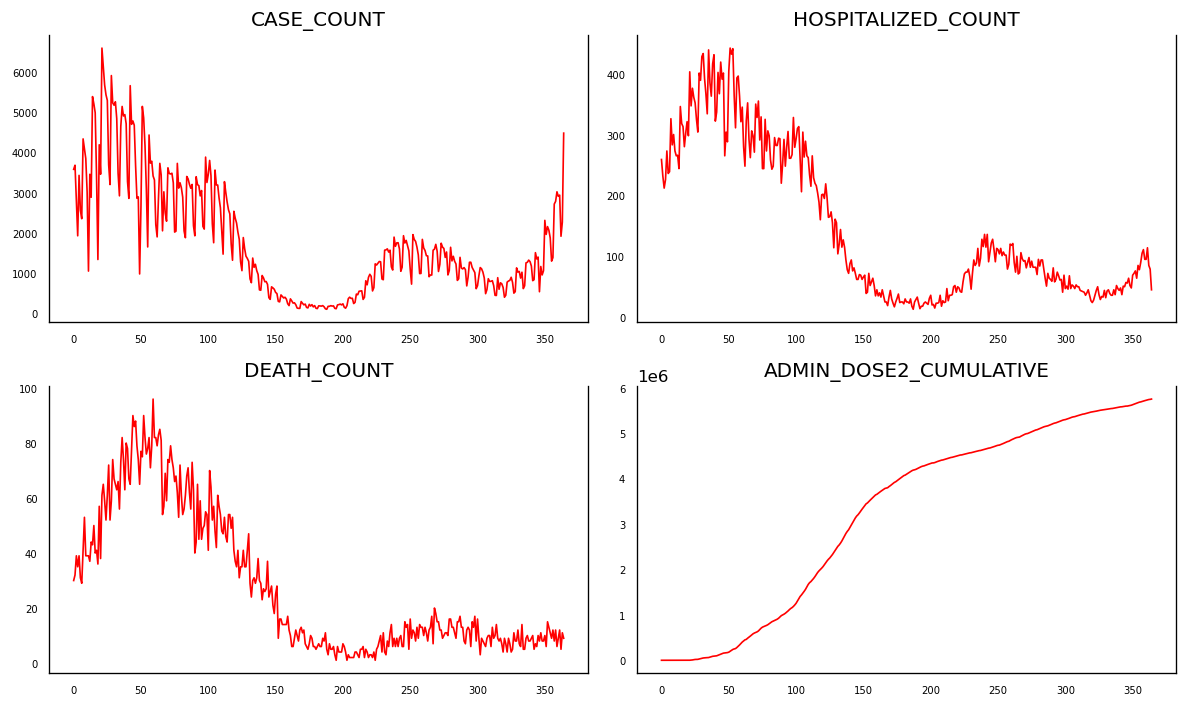

In [32]:
fig, axes = plt.subplots(nrows=2, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df_final[df_final.columns[i]]
    ax.plot(data, color='red', linewidth=1)

    ax.set_title(df_final.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [37]:
maxlag = 4
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False): 
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [38]:
grangers_causation_matrix(df_final, variables = df_final.columns)

,CASE_COUNT_x,HOSPITALIZED_COUNT_x,DEATH_COUNT_x,ADMIN_DOSE2_CUMULATIVE_x
CASE_COUNT_y,1.000,0.0,0.0006,0.0
HOSPITALIZED_COUNT_y,0.002,1.0,0.0035,0.0
DEATH_COUNT_y,0.000,0.0,1.0000,0.0
ADMIN_DOSE2_CUMULATIVE_y,0.000,0.0,0.0030,1.0


In [39]:
test_size = 7

In [61]:
df_train = df_final[:-test_size]
df_test =df_final[-test_size:]
df_differenced = df_train.diff().dropna()

In [41]:
df_differenced = df_differenced.diff().dropna()

In [44]:
model = VAR(df_differenced)
for i in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  41.31720897817742
BIC :  41.535356459274624
FPE :  8.786969177838708e+17
HQIC:  41.403993806417034 

Lag Order = 2
AIC :  40.54712722553804
BIC :  40.94061504721266
FPE :  4.0682969946863814e+17
HQIC:  40.70368346629101 

Lag Order = 3
AIC :  39.97769713063608
BIC :  40.547261830240984
FPE :  2.3022429632831363e+17
HQIC:  40.20433250435448 

Lag Order = 4
AIC :  39.684905238353345
BIC :  40.431288533639346
FPE :  1.7181694828585456e+17
HQIC:  39.98192965030246 

Lag Order = 5
AIC :  39.26979157204262
BIC :  40.19374041184642
FPE :  1.1347556163539594e+17
HQIC:  39.63751713354096 

Lag Order = 6
AIC :  38.72480491220655
BIC :  39.827071527773256
FPE :  6.582523796093946e+16
HQIC:  39.16354596212722 

Lag Order = 7
AIC :  38.30236103529285
BIC :  39.58370299224265
FPE :  4.316892866887034e+16
HQIC:  38.81243416183025 

Lag Order = 8
AIC :  38.0833481843415
BIC :  39.54452843529044
FPE :  3.47041072665996e+16
HQIC:  38.66507224704717 

Lag Order = 9
AIC :  38.01520401

C:\Users\13301\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


In [46]:
x = model.select_order(maxlags=40)
x.summary()

,AIC,BIC,FPE,HQIC
0,42.01,42.05,1.749e+18,42.02
1,40.59,40.83,4.262e+17,40.69
2,39.75,40.17,1.828e+17,39.92
3,39.24,39.85,1.098e+17,39.48
4,38.91,39.72,7.956e+16,39.24
5,38.45,39.45,5.008e+16,38.85
6,38.04,39.23,3.314e+16,38.51
7,37.63,39.01,2.208e+16,38.18
8,37.37,38.94*,1.703e+16,38.00
9,37.31,39.07,1.599e+16,38.01


In [47]:
model_fitted = model.fit(8)

In [48]:
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 17, Dec, 2021
Time:                     01:47:46
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    39.5445
Nobs:                     348.000    HQIC:                   38.6651
Log likelihood:          -8469.67    FPE:                3.47041e+16
AIC:                      38.0833    Det(Omega_mle):     2.41545e+16
--------------------------------------------------------------------
Results for equation CASE_COUNT
                               coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------------
const                             0.971205        26.169575            0.037           0.970
L1.CASE_COUNT                    -1.415108         0.067638          -20.922           0.000
L1.HOSP

In [49]:
lag_order = model_fitted.k_ar
print(lag_order)  

8


In [50]:
forecast_input = df_differenced.values[-lag_order:]
forecast_input

array([[ 1.152e+03,  2.500e+01,  2.000e+00,  5.138e+03],
       [-1.605e+03, -1.800e+01, -6.000e+00,  1.400e+01],
       [ 5.440e+02,  1.000e+00,  1.300e+01, -7.500e+01],
       [-2.840e+02, -1.600e+01, -1.100e+01,  1.230e+02],
       [-1.010e+02,  3.300e+01,  0.000e+00,  1.741e+03],
       [-3.870e+02, -2.800e+01,  0.000e+00, -1.610e+03],
       [ 6.660e+02,  1.900e+01,  5.000e+00, -5.322e+03],
       [ 1.244e+03,  3.000e+00, -7.000e+00,  4.078e+03]])

In [53]:
fc = model_fitted.forecast(y=forecast_input, steps=test_size)
df_forecast = pd.DataFrame(fc, index=df_final.index[-test_size:], columns=df_final.columns + '_2d')
df_forecast

,CASE_COUNT_2d,HOSPITALIZED_COUNT_2d,DEATH_COUNT_2d,ADMIN_DOSE2_CUMULATIVE_2d
358,-1248.287396,-3.722631,4.801226,2148.412253
359,-134.671876,0.482224,0.372854,-347.642530
360,-214.105344,-18.453926,-0.273548,-660.718473
361,309.637647,18.815925,-0.856863,1887.524974
362,-236.944217,-22.587205,-2.570446,-1611.833614
363,83.014741,16.494853,1.202925,-4159.745160
364,811.386571,13.631488,2.515911,1001.478086


In [54]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [55]:
df_results = invert_transformation(df_train, df_forecast, second_diff=True)        

In [56]:
df_results

,CASE_COUNT_2d,HOSPITALIZED_COUNT_2d,DEATH_COUNT_2d,ADMIN_DOSE2_CUMULATIVE_2d,CASE_COUNT_1d,CASE_COUNT_forecast,HOSPITALIZED_COUNT_1d,HOSPITALIZED_COUNT_forecast,DEATH_COUNT_1d,DEATH_COUNT_forecast,ADMIN_DOSE2_CUMULATIVE_1d,ADMIN_DOSE2_CUMULATIVE_forecast
358,-1248.287396,-3.722631,4.801226,2148.412253,83.712604,2796.712604,11.277369,116.277369,0.801226,8.801226,11946.412253,5.705918e+06
359,-134.671876,0.482224,0.372854,-347.642530,-50.959272,2745.753332,11.759593,128.036963,1.174080,9.975306,11598.769723,5.717517e+06
360,-214.105344,-18.453926,-0.273548,-660.718473,-265.064616,2480.688716,-6.694333,121.342630,0.900532,10.875837,10938.051250,5.728455e+06
361,309.637647,18.815925,-0.856863,1887.524974,44.573031,2525.261747,12.121592,133.464222,0.043669,10.919506,12825.576224,5.741281e+06
362,-236.944217,-22.587205,-2.570446,-1611.833614,-192.371186,2332.890561,-10.465612,122.998610,-2.526777,8.392729,11213.742610,5.752495e+06
363,83.014741,16.494853,1.202925,-4159.745160,-109.356444,2223.534117,6.029241,129.027851,-1.323852,7.068877,7053.997450,5.759549e+06
364,811.386571,13.631488,2.515911,1001.478086,702.030127,2925.564244,19.660729,148.688581,1.192058,8.260935,8055.475536,5.767604e+06


In [57]:
df_results.loc[:, ['CASE_COUNT_forecast', 'HOSPITALIZED_COUNT_forecast', 'DEATH_COUNT_forecast', 'ADMIN_DOSE2_CUMULATIVE_forecast']]

,CASE_COUNT_forecast,HOSPITALIZED_COUNT_forecast,DEATH_COUNT_forecast,ADMIN_DOSE2_CUMULATIVE_forecast
358,2796.712604,116.277369,8.801226,5.705918e+06
359,2745.753332,128.036963,9.975306,5.717517e+06
360,2480.688716,121.342630,10.875837,5.728455e+06
361,2525.261747,133.464222,10.919506,5.741281e+06
362,2332.890561,122.998610,8.392729,5.752495e+06
363,2223.534117,129.027851,7.068877,5.759549e+06
364,2925.564244,148.688581,8.260935,5.767604e+06


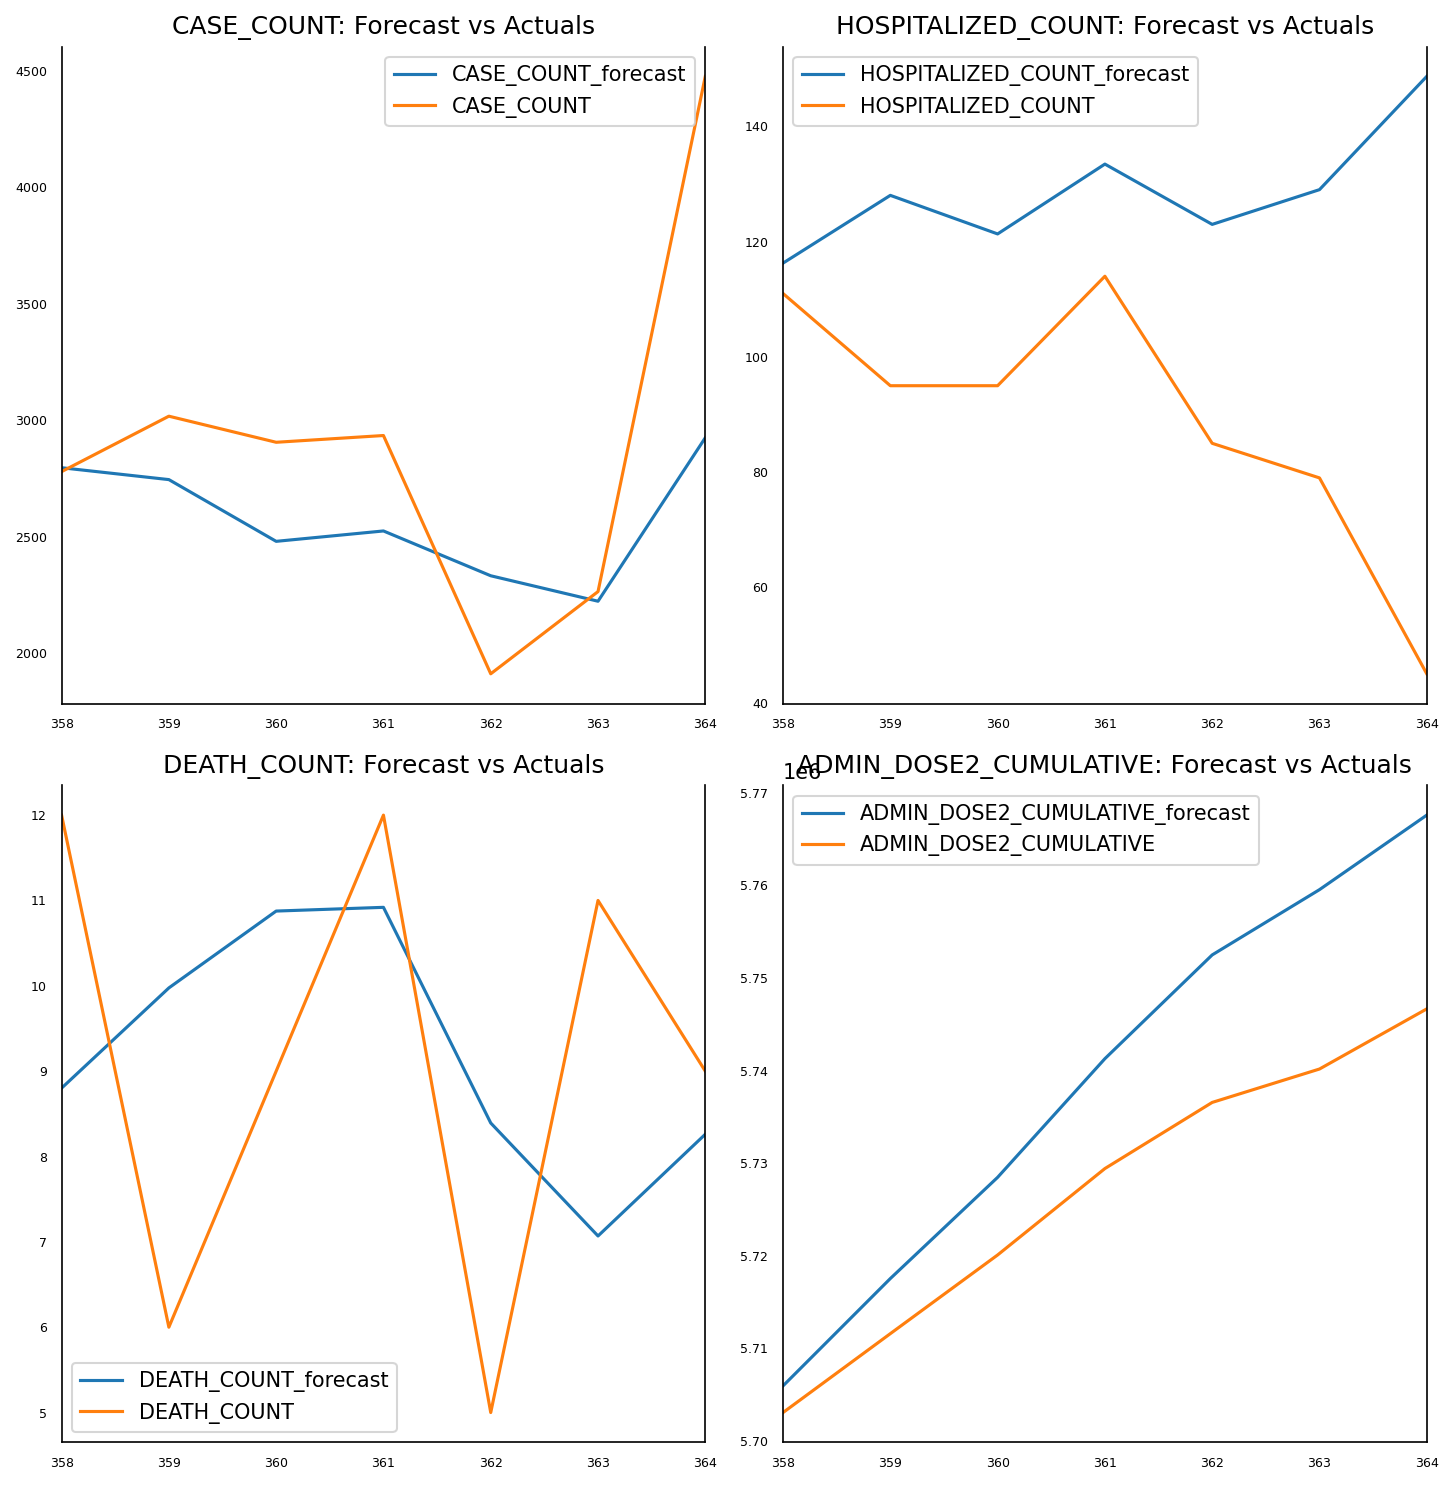

In [59]:
fig, axes = plt.subplots(nrows=int(len(df_final.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df_final.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-test_size:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [62]:
df_differenced_all = df_final.diff().dropna()
df_differenced_all = df_differenced.diff().dropna()

In [63]:
forecast_input_all = df_differenced_all.values[-lag_order:]
forecast_input

array([[ 1.152e+03,  2.500e+01,  2.000e+00,  5.138e+03],
       [-1.605e+03, -1.800e+01, -6.000e+00,  1.400e+01],
       [ 5.440e+02,  1.000e+00,  1.300e+01, -7.500e+01],
       [-2.840e+02, -1.600e+01, -1.100e+01,  1.230e+02],
       [-1.010e+02,  3.300e+01,  0.000e+00,  1.741e+03],
       [-3.870e+02, -2.800e+01,  0.000e+00, -1.610e+03],
       [ 6.660e+02,  1.900e+01,  5.000e+00, -5.322e+03],
       [ 1.244e+03,  3.000e+00, -7.000e+00,  4.078e+03]])

In [65]:
df_results_all = invert_transformation(df_final, df_forecast_all, second_diff=True) 

In [76]:
case_count = df_results['CASE_COUNT_forecast'].to_list()
hospitalized_count = df_results['HOSPITALIZED_COUNT_forecast'].to_list()
death_count = df_results['DEATH_COUNT_forecast'].to_list()
doses_count = df_results['ADMIN_DOSE2_CUMULATIVE_forecast'].to_list()

In [79]:
print(np.round(case_count))

[2797. 2746. 2481. 2525. 2333. 2224. 2926.]


In [80]:
print(np.round(hospitalized_count))

[116. 128. 121. 133. 123. 129. 149.]


In [81]:
print(np.round(death_count))

[ 9. 10. 11. 11.  8.  7.  8.]


In [82]:
print(np.round(doses_count))

[5705918. 5717517. 5728455. 5741281. 5752495. 5759549. 5767604.]


In [86]:
prediction = model_fitted.forecast(model_fitted.y, steps=7)
prediction_1 = prediction[:,0]
prediction_2 = prediction[:,1]

In [87]:
prediction_1, prediction_2

(array([-1248.28739564,  -134.6718765 ,  -214.10534402,   309.63764732,
         -236.94421697,    83.0147414 ,   811.38657124]),
 array([ -3.72263078,   0.48222427, -18.45392614,  18.81592499,
        -22.58720475,  16.49485341,  13.63148849]))